In [2]:
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def round0(x):
  return round(x, 0)

def find_border_contours(gray_img):
    blur = cv2.GaussianBlur(gray_img, (5,5), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    return cnts

def show_real_only(img, prediction, min_mouth_area, max_mouth_area):
    black = cv2.resize(np.zeros_like(img), (224, 224))
    border_contours = find_border_contours(prediction)
    print(len(border_contours))
    for c in border_contours:
        x,y,w,h = cv2.boundingRect(c)
        image_ori_small = cv2.resize(img, (224, 224))
        ROI = image_ori_small[y:y+h, x:x+w]
        roi_area = ROI.shape[0]*ROI.shape[1]
        if min_mouth_area < roi_area/(image_ori_small.shape[0]*image_ori_small.shape[1]) < max_mouth_area:
          # cv2.rectangle(ROI, (0, 0), (w, h), (36,255,12), 10)
          black[y:y+h, x:x+w] = ROI
    return black

In [6]:
def show_prediction(model):
    image_ori = cv2.imread('mouth.png')
    image = np.copy(image_ori)
    image_ori1 = np.copy(image_ori)

    image.flags.writeable = False
    image = cv2.resize(image, (224, 224))
    image1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image1 = tf.cast(image, tf.float32) / 255.0
    prediction = np.array(tf.keras.utils.array_to_img(create_mask(model.predict(image1[tf.newaxis, ...], verbose=0))))

    min_mouth_area, max_mouth_area = 0.1, 0.9 
    black_real = show_real_only(image_ori1, prediction, min_mouth_area, max_mouth_area)
    
    return black_real

c:\Users\kevin\Documents\mouth_segmentation
shape: (536, 682, 3)
1


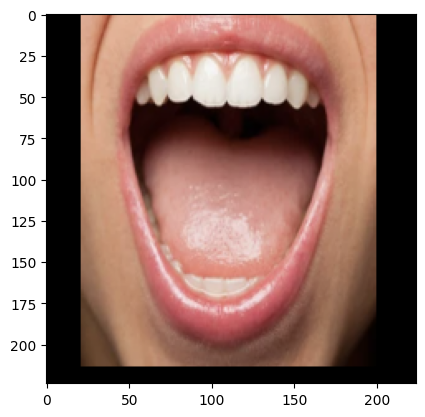

In [7]:
print(os.getcwd())
with tf.device('/cpu:0'):
    model = tf.keras.models.load_model('saved_model224/saved_model/my_model')
    plt.imshow(cv2.cvtColor(cv2.flip(show_prediction(model), 1), cv2.COLOR_BGR2RGB), cmap='brg')    
    del model
    # print(detected_key)
